# Monte Carlo Tree Search

Here I'll be trying to implement the Monte Carlo Tree Search algorithm on chess. The aim is to create this part of the self-play training pipeline in full.

Firstly, we need an instantiation of the model so we can build it into the algorithm.

In [37]:
import chess
import chess.pgn

import numpy as np
import tensorflow as tf
import keras

import itertools as it
from functools import reduce

In [2]:
# Hyperparameters
FILTERS = 256
BOARD_SHAPE = (1, 12, 8, 8)
NUM_BLOCKS = 20

In [13]:
def get_current_time():
    from datetime import datetime
    return datetime.strftime(datetime.now(), "%Y/%m/%d %H:%M:%S.%f")

def initialise_game():
    game = chess.pgn.Game()
    board = game.board()
    game.headers['Date'] = get_current_time()
    game.headers['Black'] = 'Random Agent'
    game.headers['White'] = 'Random Agent'
    return game, board

In [14]:
game, board = initialise_game()

In [65]:
def featurise_board(board):    
    board_data = np.zeros(shape = (board_depth, 8, 8))
    
    def int_to_mask(squares):
        '''Takes a set of squares as an integer and returns an 8x8 matrix of the marked squares'''
        # convert int to binary
        squares = np.binary_repr(squares, width = 64)
        # break int string into one-hot array
        squares = np.array([i for i in squares])
        # reshape into 8 by 8 matrix
        squares = squares.reshape(8, 8)
        # flip along y axis (for some reason)
        squares = squares[:, ::-1]
        return squares

    for i, piece_type in enumerate(it.product(chess.COLORS, chess.PIECE_TYPES)):
        colour, piece = piece_type
        piece_location = board.pieces_mask(color=colour, piece_type=piece)
        board_data[i, :, :] = int_to_mask(piece_location)
    
    # add castling rights
    board_data[-2, :, :] = int_to_mask(board.castling_rights)
    # add whose turn it is
    board_data[-1, :, :] = board.turn * np.ones(shape=(8,8))
            
    board_data = board_data.reshape(1, board_depth, 8, 8)
    board_data = board_data.astype(np.float32)
    return board_data

In [66]:
featurise_board(board).shape

(1, 12, 8, 8)

In [67]:
board.is_fivefold_repetition()

False

In [68]:
def uci_to_array(uci):
    # initialise as zero
    move_data = np.zeros((8, 8, 8, 8))
    prom_data = np.zeros(4)
    
    # build dicts to get board squares and promotion pieces
    letters = dict(zip('abcdefgh', range(8)))
    prom_dict = dict(zip('qrbn', range(4)))
    
    if len(uci) == 5:
        # extract promotion piece letter
        prom_data[prom_dict[uci[-1]]] = 1
        # drop promotion piece letter from uci
        uci = uci[:-1]
    
    i, j, k, l = [letters[ch] if ch in letters else int(ch) for ch in uci]
    move_data[i, j - 1, k, l - 1] = 1
    
    # flip axes to align move_array with board features
    move_data = move_data[:, ::-1, :, ::-1]
    
    # reorder move_array axes to match board feature coordinates
    move_data = move_data.transpose((1,0,3,2))
    
    # flatten move_data + prom_data into single array
    output = np.concatenate([np.ndarray.flatten(move_data), prom_data])
    return output

In [69]:
def array_to_uci(move_array, prom_data, promote = False):
    move_coords = list(np.vstack(np.where(move_array != 0)).reshape(4))
    return coords_to_uci(move_coords, prom_data, promote = promote)

In [70]:
def is_pawn_promotion(board, move_data):
    '''
    Given a board position and a move selection, this returns True
    if the given move would promote a pawn to another piece
    '''
    board_array = featurise_board(board)
    
    white_pawn = 0
    black_pawn = 6
    
    y1, x1, y2, x2 = np.where(move_data != 0)
    # checks which piece is on the current square
    piece = np.argmax(board_array[0, :, y1[0], x1[0]])
        
    if piece == white_pawn and y2[0] == 0:
        # the pawn is at the end of the board
        return True
    elif piece == black_pawn and y2[0] == 7:
        # the pawn is at the end of the board
        return True
    else:
        return False

['g8h6', 'g8f6', 'b8c6', 'b8a6', 'h7h6', 'g7g6', 'f7f6', 'e7e6', 'd7d6', 'c7c6', 'b7b6', 'a7a6', 'h7h5', 'g7g5', 'f7f5', 'e7e5', 'd7d5', 'c7c5', 'b7b5', 'a7a5']


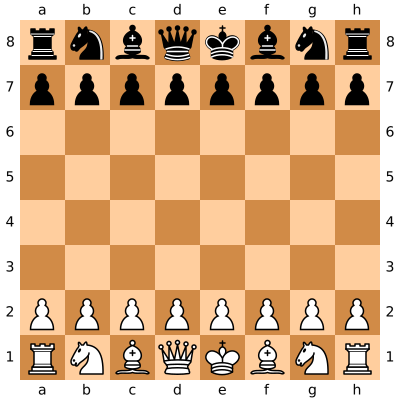

In [71]:
board = chess.Board()
# board.clear_board()
# board.set_piece_at(piece=chess.Piece(color=chess.BLACK, piece_type=chess.PAWN),
#                    square=chess.H2)
# board.set_piece_at(piece=chess.Piece(color=chess.BLACK, piece_type=chess.KNIGHT),
#                    square=chess.F3)
board.turn = False
print([m.uci() for m in board.legal_moves])
board

In [72]:
def coords_to_uci(move_coords, prom_data, promote = False):
    j, i, l, k = move_coords
    letters = dict(zip(range(8), 'abcdefgh'))
    prom_dict = dict(zip(range(4), 'qrbn'))
    result = letters[i] + str(8 - j) + letters[k] + str(8 - l)
    if promote:
        prom_piece = prom_dict[np.argmax(prom_data)]
        return result + prom_piece
    else:
        return result

In [73]:
def int_to_mask(squares):
    '''Takes a set of squares as an integer and returns an 8x8 matrix of the marked squares'''
    # convert int to binary
    squares = np.binary_repr(squares, width = 64)
    # break int string into one-hot array
    squares = np.array([i for i in squares])
    # reshape into 8 by 8 matrix
    squares = squares.reshape(8, 8)
    # flip along y axis (for some reason)
    squares = squares[:, ::-1]
    # change type to int
    squares = squares.astype(np.int0)
    return squares

In [74]:
from keras import layers

def convolutional_block(X, filters = FILTERS, kernel_size = (3, 3), 
                        activation = True):
    '''
    The convolutional block for the network. Performs convolution with a given 
    number of filters and kernel size.

    If an activation is given, then it will be applied to the output before the
    result is returned. If you want no activation function, then use 
    activation = None'''

    # run y through convolutional layer
    y = layers.Conv2D(
            filters = filters, 
            kernel_size = kernel_size,
            data_format = 'channels_first',
            padding='same')(X)

    # Apply batch normalisation
    y = tf.layers.batch_normalization(y)
    if activation:
        # Apply activation function
        y = tf.nn.relu(y)

    # return output tensor
    return y

def residual_tower(X, num_blocks = 10, filters = FILTERS):
    '''
    Constructs a residual tower consisting of a convolutional block, followed
    by a sequence of `num_blocks` residual blocks, each of with a fixed number 
    of filters.
    
    The residual tower output is passed to the policy + value heads for
    move prediction and board evaluation respectively'''
    
    def residual_block(X, activation = 'relu'):
        '''
        '''
        y = convolutional_block(X)
        y = convolutional_block(y, activation = None)
        X = convolutional_block(X, kernel_size = (1, 1), activation = None)
        y = tf.nn.relu(X + y)
        return y
    
    # Construct Residual Tower:
    y = convolutional_block(X)
    
    for i in range(num_blocks):
        y = residual_block(y)
    
    return y

def policy_head(y):
    '''
    '''
    y = convolutional_block(y, activation = True)
    y = layers.Flatten()(y)
    y = layers.Dense(units = 64 ** 2 + 4)(y)
    y = layers.Activation('softmax')(y)
    return y

def value_head(y):
    '''
    '''
    y = convolutional_block(y)
    y = layers.Flatten()(y)
    y = layers.Dense(units = FILTERS, activation = 'relu')(y)
    y = layers.Dense(units = 1, activation = 'tanh')(y)
    return y

Now we can generate random moves, we can build the model into the game simulation engine.

In [75]:
def simulate_game():
    
    # build the computational graph
    sess = tf.Session()
    X = tf.placeholder(dtype = tf.float32, shape = BOARD_SHAPE)
    res_output = residual_tower(X, num_blocks = NUM_BLOCKS)
    policy = policy_head(res_output)
    value = value_head(res_output)
    sess.run(tf.global_variables_initializer())
    
    def get_next_move(board, sess):
        input_data = featurise_board(board)

        policy_data = np.random.random(size = 4100)

        policy_data = sess.run(policy, feed_dict = {X: input_data})

        legal_moves = reduce(lambda x, y: x + y, 
            [uci_to_array(move.uci())[:-4] for move in board.legal_moves])
        # convert legal_moves into mask array
        legal_moves = legal_moves > 0
        legal_moves = legal_moves.reshape(8, 8, 8, 8)

        # separate board moves and promotions from the policy head output
        move_data = policy_data[0, :8 ** 4].reshape(8, 8, 8, 8)
        prom_data = policy_data[0, -4:]

        # do not make any illegal board moves
        move_data[~legal_moves] = 0

        # normalise move array
        move_data = move_data / np.sum(move_data)

        # select a move
        move_selection = np.random.choice(
            np.arange(np.sum(move_data > 0)), 
            p = move_data[move_data > 0])

        move_coords = np.vstack(np.where(move_data > 0))[:, move_selection]
        i, j, k, l = move_coords

        move_array = np.zeros(shape = move_data.shape)
        move_array[i, j, k, l] = 1

        # remove illegal board positions from policy output
        if not is_pawn_promotion(board, move_array):
            # do not promote a pawn if it is not legal to do so
            prom_data[:] = 0

        move_uci = coords_to_uci(
            move_coords, 
            prom_data,
            promote = is_pawn_promotion(board, move_array))
        
        print(move_uci + ", ", end = "")
        return chess.Move.from_uci(move_uci)
    
    game, board = initialise_game()
    next_move = get_next_move(board, sess)
    node = game.add_variation(next_move)
    board.push(next_move)
    while not board.is_game_over():
        next_move = get_next_move(board, sess)
        node = node.add_variation(next_move)
        board.push(next_move)
    
    game.headers['Result'] = board.result()
    
    return game, board

In [76]:
%%time
tf.reset_default_graph()
game, board = simulate_game()
print(game)

g2g3, e7e5, e2e4, b8a6, g1f3, h7h5, a2a4, f7f6, f1a6, h8h7, f3h4, f8b4, d1g4, d8e7, a6c4, b7b6, f2f4, e8f8r, b1a3, f6f5, c4f7, e5f4, h4g2, f8e8, b2b3, b4a3, f7g8, e7e4, e1f2, e8d8, f2f1, c8a6, d2d3, h7h8, g4e2, a3b2, e2f3, e4b4, a1a2, b4f8r, c2c3, h8h7, f3a8, d7d5, f1f2, d8e8, h1e1, b2a1, a2d2, e8a8, e1d1, f8e8, g8h7, b6b5, g3f4, e8h8, g2e3, a8b8, d2b2, h8e8, f2g1, e8e6, e3c4, e6e2, d1f1, e2b2, c4b6, a7b6, h2h3, b5a4, b3b4, b8c8, h7f5, g7g5, f1d1, b6b5, d1f1, c8f8, f1d1, f8a8, g1f1, b2b1, f1g1, a6b7, f5h7, a8h8, d3d4, b1b3, c1e3, a1b2, g1g2, h8a8, f4f5, a8f8, d1b1, b2a1, g2f2, b3b1, e3g5, b1g1, g5h6, a1b2, h6g5, b2a1, g5e7, f8f6, e7d6, g1e1, d6c5, f6f5, h7f5, b7a6, f5d3, e1d1, c3c4, d1c1, d3b1, a1b2, f2g2, d5c4, b1e4, c1g1, g2f3, g1g2, c5d6, g2d2, e4b1, d2g2, b1e4, g2h2, d6c5, h2h3, f3g2, h3f3, c5a7, c7c5, e4h7, f3g3, g2f1, g3g8, a7c5, g8g6, c5a7, c4c3, d4d5, g6e6, d5d6, a6b7, h7d3, e6e2, d3e4, b2a1, e4d3, e2g2, d3b1, b7d5, a7f2, d5g8, f2e1, g2e2, b1d3, g8c4, d3e2, h5h4, f1f2, a1b2, e2

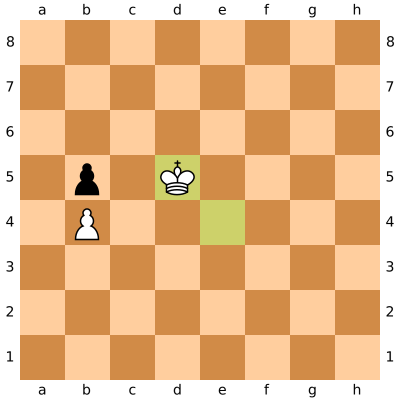

In [77]:
board

In [78]:
len(tf.get_default_graph().get_operations())

2719

In [86]:
str(board)

'. . . . . . . .\n. . . . . . . .\n. . . . . . . .\n. p . K . . . .\n. P . . . . . .\n. . . . . . . .\n. . . . . . . .\n. . . . . . . .'

In [80]:
[m.uci() for m in board.move_stack]

['g2g3',
 'e7e5',
 'e2e4',
 'b8a6',
 'g1f3',
 'h7h5',
 'a2a4',
 'f7f6',
 'f1a6',
 'h8h7',
 'f3h4',
 'f8b4',
 'd1g4',
 'd8e7',
 'a6c4',
 'b7b6',
 'f2f4',
 'e8f8r',
 'b1a3',
 'f6f5',
 'c4f7',
 'e5f4',
 'h4g2',
 'f8e8',
 'b2b3',
 'b4a3',
 'f7g8',
 'e7e4',
 'e1f2',
 'e8d8',
 'f2f1',
 'c8a6',
 'd2d3',
 'h7h8',
 'g4e2',
 'a3b2',
 'e2f3',
 'e4b4',
 'a1a2',
 'b4f8r',
 'c2c3',
 'h8h7',
 'f3a8',
 'd7d5',
 'f1f2',
 'd8e8',
 'h1e1',
 'b2a1',
 'a2d2',
 'e8a8',
 'e1d1',
 'f8e8',
 'g8h7',
 'b6b5',
 'g3f4',
 'e8h8',
 'g2e3',
 'a8b8',
 'd2b2',
 'h8e8',
 'f2g1',
 'e8e6',
 'e3c4',
 'e6e2',
 'd1f1',
 'e2b2',
 'c4b6',
 'a7b6',
 'h2h3',
 'b5a4',
 'b3b4',
 'b8c8',
 'h7f5',
 'g7g5',
 'f1d1',
 'b6b5',
 'd1f1',
 'c8f8',
 'f1d1',
 'f8a8',
 'g1f1',
 'b2b1',
 'f1g1',
 'a6b7',
 'f5h7',
 'a8h8',
 'd3d4',
 'b1b3',
 'c1e3',
 'a1b2',
 'g1g2',
 'h8a8',
 'f4f5',
 'a8f8',
 'd1b1',
 'b2a1',
 'g2f2',
 'b3b1',
 'e3g5',
 'b1g1',
 'g5h6',
 'a1b2',
 'h6g5',
 'b2a1',
 'g5e7',
 'f8f6',
 'e7d6',
 'g1e1',
 'd6c5',
 'f6f5',
 'h7f5',